In [1]:
import xarray as xr
import numpy as np
import numpy as np
import xarray as xr
import os.path as op
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
from xgcm import Grid
from scipy import linalg as lin
from scipy import signal as sig
from scipy import fftpack as fft
from scipy import interpolate as naiso
from matplotlib import colors, ticker, cm
from dask.diagnostics import ProgressBar
from floater import generators

%matplotlib inline

In [2]:
ddir = '/swot/SUM04/dbalwada/channel_beta/01km'
outdir = '/swot/SUM01/takaya/ftle/input/'
res = 1
tp = '>f8'

In [13]:
dt = 40
df = int(3600/40)
dfend = 378000

In [22]:
print(np.arange(int(dfend-31*86400/dt),int(dfend-36*86400/dt-int(2*df)),-df),int(dfend-31*86400/dt),
     len(np.arange(int(dfend-31*86400/dt),int(dfend-36*86400/dt-int(2*df)),-df)))

[311040 310950 310860 310770 310680 310590 310500 310410 310320 310230
 310140 310050 309960 309870 309780 309690 309600 309510 309420 309330
 309240 309150 309060 308970 308880 308790 308700 308610 308520 308430
 308340 308250 308160 308070 307980 307890 307800 307710 307620 307530
 307440 307350 307260 307170 307080 306990 306900 306810 306720 306630
 306540 306450 306360 306270 306180 306090 306000 305910 305820 305730
 305640 305550 305460 305370 305280 305190 305100 305010 304920 304830
 304740 304650 304560 304470 304380 304290 304200 304110 304020 303930
 303840 303750 303660 303570 303480 303390 303300 303210 303120 303030
 302940 302850 302760 302670 302580 302490 302400 302310 302220 302130
 302040 301950 301860 301770 301680 301590 301500 301410 301320 301230
 301140 301050 300960 300870 300780 300690 300600 300510 300420 300330
 300240 300150] 311040 122


In [24]:
veliter = 0
nx = 2000
ny = 2000

# for i in range(int(dfend-31*86400/dt),dfend,df):
for i in np.arange(int(dfend-31*86400/dt),int(dfend-41*86400/dt-int(2*df)),-df):
# for i in range(int(dfend-16*86400/dt),dfend,df):
    ds = open_mdsdataset(op.join(ddir, 'tracer_exp2'),
                        iters = i,
                        prefix=['U','V'], delta_t=dt
                        ).sel(
#                              YC=slice(8e5,12e5),YG=slice(8e5,12e5),
#                              XC=slice(14e5,None),XG=slice(14e5,None),
#                              Z=slice(None,-1000), Zl=slice(None,-1000), Zp1=slice(None,-1016), Zu=slice(None,-1016)
                             )
    if i == int(dfend-31*86400/dt):
        print(ds)
    ds.U[0,0].values.astype(tp).tofile(outdir + 'offVel/U_1hrSnap_backward_%03dkm_x%04d-y%04d.%010d.data' 
                                      % (res,nx,ny,int(veliter*2)))
    ds.V[0,0].values.astype(tp).tofile(outdir + 'offVel/V_1hrSnap_backward_%03dkm_x%04d-y%04d.%010d.data' 
                                      % (res,nx,ny,int(veliter*2)))
    veliter += 1
#     if i == int(dfend-30*86400/dt):
#         print(ds)
#         u = ds.U[:,:2].load()
#         v = ds.V[:,:2].load()
#     else:
#         u = xr.concat([u,ds.U[:,:2].load()], dim='time')
#         v = xr.concat([v,ds.V[:,:2].load()], dim='time')

<xarray.Dataset>
Dimensions:              (XC: 2000, XG: 2000, YC: 2000, YG: 2000, Z: 76, Zl: 76, Zp1: 77, Zu: 76, layer_1TH_bounds: 43, layer_1TH_center: 42, layer_1TH_interface: 41, time: 1)
Coordinates:
    iter                 (time) int64 311040
  * time                 (time) int64 12441600
  * XC                   (XC) >f4 500.0 1500.0 2500.0 ... 1998500.0 1999500.0
  * YC                   (YC) >f4 500.0 1500.0 2500.0 ... 1998500.0 1999500.0
  * XG                   (XG) >f4 0.0 1000.0 2000.0 ... 1998000.0 1999000.0
  * YG                   (YG) >f4 0.0 1000.0 2000.0 ... 1998000.0 1999000.0
  * Z                    (Z) >f4 -0.5 -1.57 -2.79 ... -2757.325 -2912.665
  * Zp1                  (Zp1) >f4 0.0 -1.0 -2.14 ... -2689.32 -2825.33 -3000.0
  * Zu                   (Zu) >f4 -1.0 -2.14 -3.44 ... -2689.32 -2825.33 -3000.0
  * Zl                   (Zl) >f4 0.0 -1.0 -2.14 ... -2562.59 -2689.32 -2825.33
    rA                   (YC, XC) >f4 dask.array<shape=(2000, 2000), chunksize=

In [19]:
grid = Grid(ds, periodic=[])
grid

<xgcm.Grid>
1TH Axis (not periodic):
  * center   layer_1TH_center --> outer
  * outer    layer_1TH_bounds --> center
  * inner    layer_1TH_interface --> center
Y Axis (not periodic):
  * center   YC --> left
  * left     YG --> center
T Axis (not periodic):
  * center   time
X Axis (not periodic):
  * center   XC --> left
  * left     XG --> center
Z Axis (not periodic):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center

In [20]:
with ProgressBar():
    vort = (grid.diff(ds.V[0,0]*ds.dyC,'X',boundary='fill')/ds.rAz 
            - grid.diff(ds.U[0,0]*ds.dxC,'Y',boundary='fill')/ds.rAz).compute()
vort

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.4s


<xarray.DataArray (YG: 2000, XG: 2000)>
array([[ 0.000000e+00,  0.000000e+00,  0.000000e+00, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 1.336639e-05,  1.123264e-05,  1.040892e-05, ...,  1.871931e-05,
         1.538245e-05,  1.425706e-05],
       [ 5.680254e-05,  3.389394e-05,  1.674139e-05, ...,  2.499926e-05,
         3.654947e-05,  4.768882e-05],
       ...,
       [-9.427720e-06, -1.010458e-05, -1.035087e-05, ..., -7.905518e-06,
        -8.647559e-06, -9.277355e-06],
       [ 1.304592e-05,  1.436357e-05,  1.416706e-05, ...,  1.587772e-05,
         1.541630e-05,  1.499784e-05],
       [ 5.036256e-05,  5.236311e-05,  5.276763e-05, ...,  5.094363e-05,
         5.127636e-05,  5.162571e-05]], dtype=float32)
Coordinates:
  * YG       (YG) >f4 0.0 1000.0 2000.0 3000.0 ... 1997000.0 1998000.0 1999000.0
  * XG       (XG) >f4 0.0 1000.0 2000.0 3000.0 ... 1997000.0 1998000.0 1999000.0
    rAz      (YG, XG) >f4 1000000.0 1000000.0 1000000.0 ... 1000000.0 1000000.0

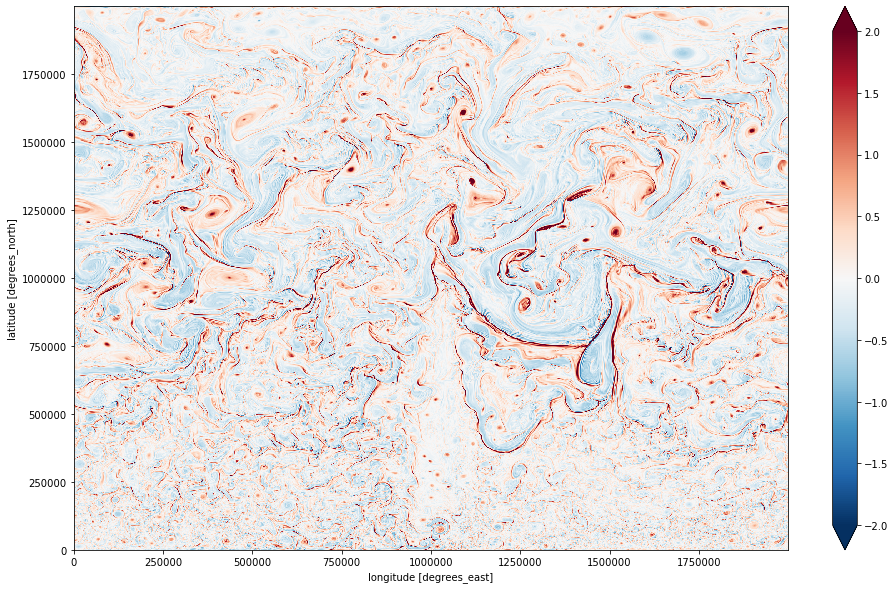

In [22]:
(vort*-0.83e-4**-1).plot(figsize=(16,10), vmax=2)